<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Mod%C3%A9lisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Avant de commencer à run ce notebook, il faut charger un certain nombre de fichiers : 


```
- test_review.csv.zip
- train_review.csv.zip
- unsup_filtered_review.csv.zip
```



Import des modules nécessaires

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np
import random as rd

In [ ]:
rd.seed(42)

Import des bases : 
- *df* contient la base TMDb
- *train_review* contient la partie entraînée sur les reviews labellisés
- *test_review* contient la partie test sur les reviews labellisés
- *unsup_filtered_review* contient les reviews non labellisés filtrés sur les films contenus dans *df*



In [ ]:
 df = pd.read_csv('https://raw.githubusercontent.com/marie-ganon/Projet-Python-S1/main/Bases_import%C3%A9es/base.csv')

Avant de modéliser quoi que ce soit, nous allons supprimer les 'NaN' de la base de données.

In [ ]:
df = df.dropna()
df = df.drop(columns='Unnamed: 0')

In [ ]:
# Fichier temporaire

import tempfile

temp_dir = tempfile.mkdtemp()

# Pour dezipper le csv disponible dans le git 

import zipfile

# IMPORTER LES FICHIERS TEST_REVIEW.CSV.ZIP et TRAIN_REVIEW.CSV.ZIP
with zipfile.ZipFile('test_review.csv.zip', 'r') as zip1, zipfile.ZipFile('train_review.csv.zip', 'r') as zip2 :
    zip1.extractall('temp_dir')
    zip2.extractall('temp_dir')

test_review = pd.read_csv(r'temp_dir/test_review.csv', sep=',', low_memory = False)
train_review = pd.read_csv(r'temp_dir/train_review.csv', sep=',', low_memory = False)


FileNotFoundError: ignored

# Observations des bases

## Analyse de la matrice de corrélation de *df*

Rappelons la matrice de corrélation de la base :

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count,collection,score_1,production_companies_id,pc_id_count
index,1.000000,-0.111052,0.675912,-0.113959,-0.083023,-0.171586,-0.239960,-0.071127,-0.102720,-0.072469,0.331970,-0.229618
budget,-0.111052,1.000000,-0.086690,0.412162,0.766446,0.225766,0.103634,0.665415,0.212146,0.622080,-0.160624,0.117158
id,0.675912,-0.086690,1.000000,-0.014127,-0.060123,-0.086692,-0.141201,-0.033574,-0.122764,-0.034831,0.367358,-0.186671
popularity,-0.113959,0.412162,-0.014127,1.000000,0.495219,0.161276,0.186538,0.544388,0.184730,0.534342,-0.143197,0.050937
revenue,-0.083023,0.766446,-0.060123,0.495219,1.000000,0.183763,0.137679,0.806602,0.284759,0.780984,-0.125020,0.108120
runtime,-0.171586,0.225766,-0.086692,0.161276,0.183763,1.000000,0.231019,0.199476,-0.016943,0.200588,-0.105164,0.068359
vote_average,-0.239960,0.103634,-0.141201,0.186538,0.137679,0.231019,1.000000,0.203592,0.019937,0.212963,-0.116379,0.048969
vote_count,-0.071127,0.665415,-0.033574,0.544388,0.806602,0.199476,0.203592,1.000000,0.246816,0.994176,-0.134497,0.080398
collection,-0.102720,0.212146,-0.122764,0.184730,0.284759,-0.016943,0.019937,0.246816,1.000000,0.228573,-0.100320,0.036184
score_1,-0.072469,0.622080,-0.034831,0.534342,0.780984,0.200588,0.212963,0.994176,0.228573,1.000000,-0.126350,0.075440


Par construction de *score_1*, il n'est pas choquant d'observer une forte corrélation avec *popularity*, *vote_count* et *vote_average*.

On constate que bien qu'il y ait peu de données qui puissent être exploitées pour le budget et le revenu d'un film, ces deux variables sont cependant corrélées avec *score_1*, qui permet de quantifier la qualité d'un film.

Par ailleurs, la compagnie de production et la durée du film ne semblent guère influencer sa qualité. 

## Complétude des deux bases

# Régression linéaire de *score_1* sur *budget* et *revenue*

Tout d'abord, récupérons les données nécessaires dans le dataset.

In [ ]:
X = pd.DataFrame(np.c_[df.budget, df.revenue], columns= ['budget', 'revenue'])
Y = df.score_1

Séparons ensuite nos deux ensembles de données en bases d'apprentissage et de test.

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13884, 2)
(3472, 2)
(13884,)
(3472,)


## Régression linéaire 

On effectue alors la régression linéaire voulue.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Evaluons les performances du modèle sur l'échantillon d'apprentissage et sur celui de test :

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 3467.4302151622496
Le score R² est 0.6162165165800999


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 3364.076265294737
Le score R² est 0.5879873205932651


Bien que le $R^2$ soit plutôt bon, ce modèle génère une erreur quadratique moyenne assez forte sur la valeur de *score_1* (de l'ordre de 3400). Cela est certainement dû à la dispersion de *score_1* :

In [ ]:
df.score_1.describe()

count     17356.000000
mean       1709.543046
std        5527.962377
min           0.000000
25%          44.800000
50%         170.000000
75%         857.700000
max      114007.500000
Name: score_1, dtype: float64

## Régression linéaire tronquée

Etudions les perfomances de ce modèle sur un échantillon comprenant les valeurs de *score_1* allant du 1er au 3ème quartile :

In [ ]:
first_quart = np.percentile(df.score_1, 25)
third_quart = np.percentile(df.score_1, 75)

In [ ]:
# Filtration des données
df_quart = df[df.score_1 > first_quart]
df_quart = df[df.score_1 < third_quart]

# Création des variables nécessaires
X2 = pd.DataFrame(np.c_[df_quart.budget, df_quart.revenue], columns= ['budget', 'revenue'])
Y2 = df_quart.score_1
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.2, random_state=5)

# Lancement de la régression linéaire
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train2, Y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict2 = lmodellineaire.predict(X_train2)
rmse = (np.sqrt(mean_squared_error(Y_train2, y_train_predict2)))
r2 = r2_score(Y_train2, y_train_predict2)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict2 = lmodellineaire.predict(X_test2)
rmse = (np.sqrt(mean_squared_error(Y_test2, y_test_predict2)))
r2 = r2_score(Y_test2, y_test_predict2)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 188.1704456835393
Le score R² est 0.1454504867917935


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 181.4256396942466
Le score R² est 0.1529228653745578


Par cette nouvelle régression, nous avons certes diminué drastiquement l'erreur quadratique moyenne, cependant le $R^2$ a été divisé par 4.

## Comparaison graphique des résultats

Comparons graphiquement les résultats de la prédiction pour ces deux régressions.

In [ ]:
def plot(test, predict):
  fig, ax = plt.subplots(figsize=(8,5))
  p1 = sns.distplot(test, label = 'Vraie valeur')
  p2 = sns.distplot(predict, label = 'Prédiction')
  ax.set(xlabel= 'Valeur de score_1', ylabel = 'Densité')
  fig.legend(labels=['Vraie valeur','Prédiction'], loc = (0.75, 0.5))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/di

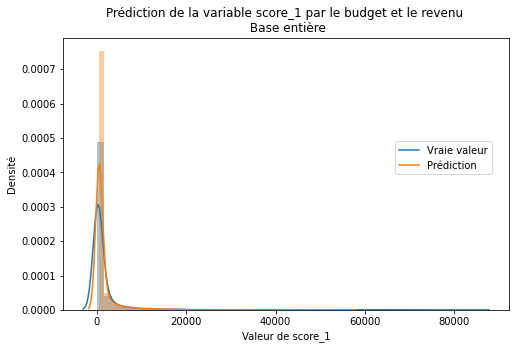

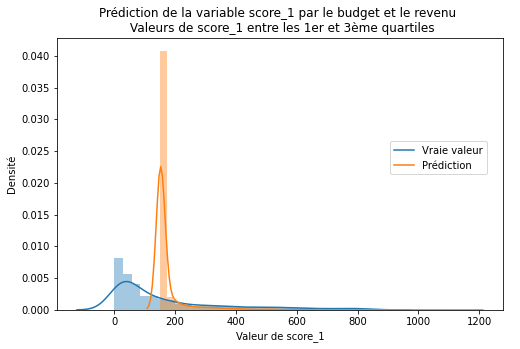

In [ ]:
plot(Y_test,y_test_predict)
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Base entière')

plot(Y_test2, y_test_predict2)
plt.title('Prédiction de la variable score_1 par le budget et le revenu \n Valeurs de score_1 entre les 1er et 3ème quartiles')

plt.show()

Grâce à ces graphiques, on remarque qu'effectivement la première régression est nettement plus efficace que la seconde pour prédire les valeurs de *score_1*. Cependant, l'algorithme a plus de mal à prédire précisément les petites valeurs de *score_1*.

# Sentiment analysis 






L'idée derrière cette partie sur l'analyse sentiment des commentaires des spectateurs est de créer un modèle capable de prédire correctement si les sentiments dégagés par les commentaires sont positifs ou négatifs. On dispose ici de bases déjà labellisées. Mais ce travail pourrait permettre d'améliorer nos modèles en s'intéressant à une base plus importante de commentaires que l'on pourrait scraper et sur laquelle on pourrait tourner notre outil de prédiction de sentiments.


## Préparation des données

On va tenter d'enrichir notre base en rajoutant l'analyse sentiment des commentaires associés aux films. Pour cela, on importe les base *train_review.csv.zip* et *test_review.csv.zip*. 


In [ ]:
train_review = pd.read_csv(r'/temp_dir/train_review.csv', sep=',')
test_review = pd.read_csv(r'/temp_dir/test_review.csv', sep=',')

FileNotFoundError: ignored

In [ ]:
train_review.head()

,Unnamed: 0,review,sentiment,url_code,rating,imdb_id,code_url
0,0,Working with one of the best Shakespeare sourc...,0,1821,4,tt0125430,1821
1,1,"Well...tremors I, the original started off in ...",0,10402,1,tt0334541,10402
2,2,Ouch! This one was a bit painful to sit throug...,0,1062,4,tt0043809,1062
3,3,"I've seen some crappy movies in my life, but t...",0,9056,1,tt0219400,9056
4,4,"""Carriers"" follows the exploits of two guys an...",0,5392,3,tt0806203,5392


In [ ]:
print(len(train_review), len(test_review))

24998 24998


On va garder les *review* des films présents dans la base *df*.

In [ ]:
l = []
l_rtest = pd.unique(test_review.imdb_id)
l_rtrain = pd.unique(train_review.imdb_id)
for elem in df.imdb_id:
  if elem in l_rtest or elem in l_rtrain : 
    l.append(elem)


In [ ]:
cond = test_review.apply ( lambda row : row['imdb_id'] in l , axis = 1 )
test_filtered = test_review[cond]

print('On a supprimé', len(test_review)-len(test_filtered), 'reviews de films non attribués dans la base')

On a supprimé 15318 reviews de films non attribués dans la base


In [ ]:
cond = train_review.apply ( lambda row : row['imdb_id'] in l , axis = 1 )
train_filtered = train_review[cond]

print('On a supprimé', len(train_review)-len(train_filtered), 'reviews de films non attribués dans la base')

On a supprimé 15094 reviews de films non attribués dans la base


On va pouvoir associer les deux dataframe construits. 

In [ ]:
review_filtered = pd.concat([train_filtered, test_filtered]).reset_index()
print(len(review_filtered))

19584


In [ ]:
review_filtered = review_filtered.drop(columns='Unnamed: 0')
review_filtered.head()

,index,review,sentiment,url_code,rating,imdb_id,code_url
0,1,"Well...tremors I, the original started off in ...",0,10402,1,tt0334541,10402
1,2,Ouch! This one was a bit painful to sit throug...,0,1062,4,tt0043809,1062
2,3,"I've seen some crappy movies in my life, but t...",0,9056,1,tt0219400,9056
3,4,"""Carriers"" follows the exploits of two guys an...",0,5392,3,tt0806203,5392
4,5,I had been looking forward to seeing this film...,0,2682,3,tt0120620,2682


On tokenize puis on enlève les stopwords.

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

reviews = review_filtered.review.str.cat(sep=' ')
# on découpe selon les mots
tokens = word_tokenize(reviews)
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
words=[word.lower() for word in tokens if word.isalpha()]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
vocabulary = set(words)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(words)
print('les 10 mots les plus fréquents',sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:20])


62144
les 10 mots les plus fréquents ['br', 'i', 'movie', 'the', 'film', 'one', 'like', 'it', 'good', 'this', 'would', 'even', 'time', 'really', 'story', 'see', 'great', 'well', 'much', 'could']


Il y a encore quelques stop words qu'on va retirer. On rajoute les mots pertinents à retirer dans la liste *to_remove* jusqu'à ce que la liste des 10 mots les plus fréquents contienne des termes sans stopwords ainsi qu'uniquement des mots pertinents (par exemple *movies* ou *film* ne sont pas très pertinents puisque tous les objets sont des films ici).

In [ ]:
to_remove = ['i','br', 'the','this', 'it', 'one', 'movie', 'film']
words = [word for word in words if word not in to_remove]

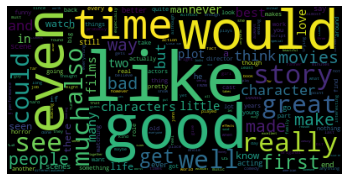

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
vocabulary = set(words)
frequency_dist = nltk.FreqDist(words)
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Comme nous utilisons des subsets des bases d'apprentissage et d'entraînement initialement fournies, nous allons recréer ces bases pour notre modèle de sentiment analysis. 

In [ ]:
n_max = len(review_filtered)/2
n_max 

9792.0

In [ ]:
print(len(review_filtered.loc[:n_max-1, 'review'].values), len(review_filtered.loc[n_max:,'review'].values))

9792 9792


In [ ]:
x_train = review_filtered.loc[:n_max-1, 'review'].values
y_train = review_filtered.loc[:n_max-1, 'sentiment'].values
x_test = review_filtered.loc[n_max:,'review'].values
y_test = review_filtered.loc[n_max:,'sentiment'].values

## Classificateur naïf bayésien

On préprocess le texte avec *TFidfTransformer* : 

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
print(train_vectors.shape, test_vectors.shape)

(9792, 48607) (9792, 48607)


On utilise un classifier naïf bayésien pour entraîner notre modèle.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, y_train)

Maintenant que le modèle est entraîné, on s'intéresse au score :

In [ ]:
from  sklearn.metrics  import accuracy_score
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))


0.8278186274509803


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
tab = pd.DataFrame([[accuracy_score(y_test, predicted)], [f1_score(y_test, predicted)],[precision_score(y_test, predicted)], [recall_score(y_test, predicted)]], index=['accuracy', 'f1', 'precision', 'recall'], columns = ['score'])
tab

,score
accuracy,0.827819
f1,0.838506
precision,0.840922
recall,0.836103


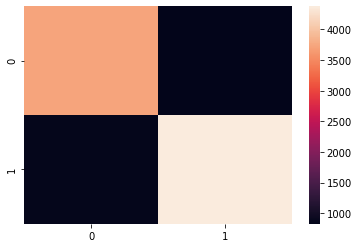

In [ ]:
c = confusion_matrix(y_test, predicted)
sns.heatmap(c)

On obtient un score de 84,71% sur la prédiction des sentiments positifs ou négatifs générés par les commentaires utilisateurs. On voit sur la matrice de confiance que les erreurs de type I (faux positifs) et de type II (faux négatifs) sont marginales. 
A priori, le classificateur est performant, mais il se trouve que SVM est une méthode d'ordinaire meilleure que le classificateur naïf bayésien. 
On va essayer d'améliorer ce score en utilisant un SVM plutôt qu'un classificateur naïf bayésien. L'avantage du classificateur naïf bayésien en dépit de sa performance est la rapidité d'exécution par rapport au SVM.

### 5-fold validation croisée

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, train_vectors, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.87799898 0.87442573 0.88508682 0.86210419 0.88100102]


## Classificateur SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import SVC
clf_svm = SVC(kernel='linear', C=1)
clf_svm.fit(train_vectors, y_train)
y_pred = clf.predict(test_vectors)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
tab = pd.DataFrame([[accuracy_score(y_test, y_pred)], [f1_score(y_test, y_pred)],[precision_score(y_test,y_pred)], [recall_score(y_test, y_pred)]], index=['accuracy', 'f1', 'precision', 'recall'], columns = ['score'])
tab

,score
accuracy,0.872141
f1,0.879221
precision,0.888131
recall,0.870487


En effet, le score en SVM est un peu plus élevé, avec une précision de 87,21%. Le temps d'exécution est bien plus long en revanche. 

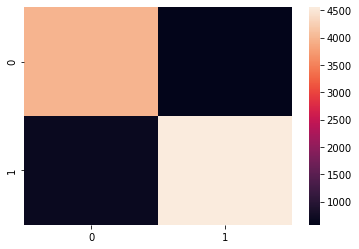

In [ ]:
c = confusion_matrix(y_test, y_pred)
sns.heatmap(c)

La matrice de confusion est à peu près inchangée.

### 5-fold validation croisée SVM

In [ ]:
scores = cross_val_score(clf_svm, train_vectors, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

KeyboardInterrupt: ignored

# Approfondissement de la régression


A présent, on va rajouter à la base les données de score imdb associés aux commentaires et la nature des commentaires (positifs ou négatifs) afin de voir si cela améliore la régression sur le score.

## Préparation des données

In [ ]:
gr_review = review_filtered.groupby('imdb_id').mean()
#gr_review = gr_review.drop(columns=['Unnamed: 0', 'url_code'])


In [ ]:
print(len(pd.unique(review_filtered.imdb_id)))

1779


In [ ]:
df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')
print(len(df_2))

1779


In [ ]:
corr = df_2[['budget', 'revenue', 'runtime', 'score_1', 'sentiment', 'rating']].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,budget,revenue,runtime,score_1,sentiment,rating
budget,1.000000,0.688175,0.253552,0.534138,-0.019571,-0.023178
revenue,0.688175,1.000000,0.249538,0.780262,0.011856,0.013321
runtime,0.253552,0.249538,1.000000,0.271800,0.047998,0.048769
score_1,0.534138,0.780262,0.271800,1.000000,0.028201,0.033916
sentiment,-0.019571,0.011856,0.047998,0.028201,1.000000,0.970471
rating,-0.023178,0.013321,0.048769,0.033916,0.970471,1.000000


In [ ]:
X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.rating, df_2.sentiment], columns= ['budget', 'revenue', 'rating', 'sentiment'])
Y = df_2.score_1

## Régression linéaire avec ajout de "rating" et "sentiment"

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)


(1423, 4)
(356, 4)
(1423,)
(356,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 2752.321358120113
Le score R² est 0.6343109257881477


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 2775.3429568595857
Le score R² est 0.45310047648624907


Il semblerait que l'ajout de variables supplémentaires diminue la qualité de la prédiction. En effet, on passe d'un $R^2$ de 59% à 45%, même si on diminue l'erreur quadratique.

## Régression tronquée

Sur les 1er et 3e quartiles. 

In [ ]:
first_quart = np.percentile(df_2.score_1, 25)
third_quart = np.percentile(df_2.score_1, 75)

# Filtration des données
df_quart = df_2[df_2.score_1 > first_quart]
df_quart = df_2[df_2.score_1 < third_quart]

# Création des variables nécessaires
X2 = pd.DataFrame(np.c_[df_quart.budget, df_quart.revenue], columns= ['budget', 'revenue'])
Y2 = df_quart.score_1
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.2, random_state=5)

# Lancement de la régression linéaire
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train2, Y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict2 = lmodellineaire.predict(X_train2)
rmse = (np.sqrt(mean_squared_error(Y_train2, y_train_predict2)))
r2 = r2_score(Y_train2, y_train_predict2)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict2 = lmodellineaire.predict(X_test2)
rmse = (np.sqrt(mean_squared_error(Y_test2, y_test_predict2)))
r2 = r2_score(Y_test2, y_test_predict2)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 173.1820015609836
Le score R² est 0.20264541422578397


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 160.19713029033295
Le score R² est 0.21978490918629323


On a encore diminué l'erreur quadratique moyenne par rapport aux premières régressions linéaires mais le $R^2$ est toujours très très faible ce qui indique une mauvaise qualité de la prédiction. Il faut noter que si on a rajouté deux features pertinents à la régression, ce rajout nous a fait perdre de l'information puisque l'échantillon a été diminué à 1779 films.

## Comparaison graphique des deux régressions

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/di

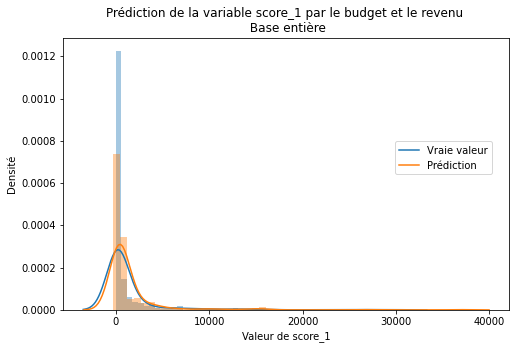

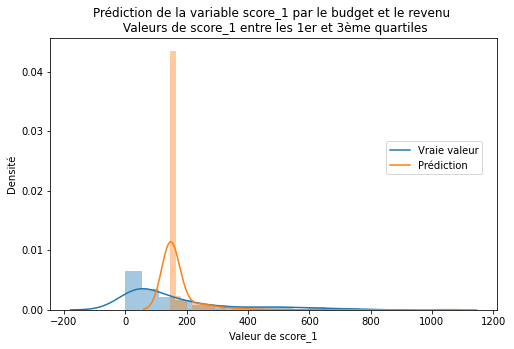

In [ ]:
plot(Y_test,y_test_predict)
plt.title('Prédiction de la variable score_1 par le budget, le revenu, sentiment et rating \n Base entière')

plot(Y_test2, y_test_predict2)
plt.title('Prédiction de la variable score_1 par le budget, le revenu, sentiment et rating \n Valeurs de score_1 entre les 1er et 3ème quartiles')

plt.show()

# Ajout du semi supervisé sur les commentaires

Le dernier modèle a été un peu amélioré mais l'échantillon ayant beaucoup été diminué, on va essayer d'inclure davantage de commentaires pour améliorer la régression linéaire sur un sous ensemble plus important de notre base.

In [ ]:
# IMPORTER LE FICHIER UNSUP_FILTERED.CSV.ZIP
with zipfile.ZipFile(r'unsup_filtered_review.csv.zip', 'r') as zip :
      zip.extractall('temp_dir')

unsup_filtered = pd.read_csv(r'unsup_filtered_review.csv', sep=',', low_memory = False)



## Pseudo-labelisation des commentaires

On va utiliser notre outil d'analyse sentiment sur cette base pour agrandir la base des commentaires. 

In [ ]:
x_train = review_filtered.loc[:n_max-1, 'review'].values
y_train = review_filtered.loc[:n_max-1, 'sentiment'].values
x_test = review_filtered.loc[n_max:,'review'].values
y_test = review_filtered.loc[n_max:,'sentiment'].values
x_test_ul = unsup_filtered['review'].values

In [ ]:
review_filtered = review_filtered.drop(columns=['index','rating'])
review_filtered.head()

,review,sentiment,url_code,imdb_id,code_url
0,"Well...tremors I, the original started off in ...",0,10402,tt0334541,10402
1,Ouch! This one was a bit painful to sit throug...,0,1062,tt0043809,1062
2,"I've seen some crappy movies in my life, but t...",0,9056,tt0219400,9056
3,"""Carriers"" follows the exploits of two guys an...",0,5392,tt0806203,5392
4,I had been looking forward to seeing this film...,0,2682,tt0120620,2682


In [ ]:
unsup_filtered = unsup_filtered.drop(columns='Unnamed: 0')

In [ ]:
unsup_filtered.head()

,review,url_code,code_url,imdb_id,sentiment
0,"Very good film from director Wyler, although i...",1597,1597,tt0030287,1
1,"This flick will pass the time, and Kurt Russle...",27082,27082,tt0089572,0
2,Here is another of those films that got panned...,30084,30084,tt0163978,1
3,"Not sure how a filmmaker as prolific as Joel ""...",6087,6087,tt0450336,0
4,What? I watched this movie with my two young n...,49665,49665,tt0457419,0


On utilise notre classificateur naïf de bayes (pour la rapidité) qu'en entraîne avec les données labelisées.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
clf = MultinomialNB().fit(train_vectors, y_train)

from  sklearn.metrics  import accuracy_score
predicted = clf.predict(test_vectors)

On l'applique aux données non labelisées. On va créer une fonction qui prend en argument la proportion du sample que dont on prédit la labelisation.

In [ ]:
def label_percent(n_label): #n_label entre 0 et 1
  test_vectors_ul = vectorizer.transform(x_test_ul[:int(len(unsup_filtered)*n_label)])
  predicted_2 = clf.predict(test_vectors_ul)
  # On reconstitue un dataset avec les données labelisées et pseudo-labelisées via notre classificateur naïf bayésien
  df_unsup = unsup_filtered[:int(len(unsup_filtered)*n_label)]
  df_unsup['sentiment'] = predicted_2
  df = pd.concat([review_filtered, df_unsup])
  return df 

## Amélioration de la régression linéaire
Pour 20% de la base non labelisée : 

In [ ]:
df_pseudo_labeled = label_percent(0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
gr_review = df_pseudo_labeled.groupby('imdb_id').mean()
print(len(gr_review))
#gr_review = gr_review.drop(columns=['Unnamed: 0', 'url_code'])
df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')
print(len(df_2))

X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.sentiment], columns= ['budget', 'revenue', 'sentiment'])
Y = df_2.score_1

3989
3050


In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

(2440, 3)
(610, 3)
(2440,)
(610,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 2923.128003349665
Le score R² est 0.6209375264857289


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 2595.5322812124464
Le score R² est 0.6341989897920716


Pour 50% de la base pseudo-labelisée :

In [ ]:
df_pseudo_labeled = label_percent(0.5)

gr_review = df_pseudo_labeled.groupby('imdb_id').mean()
print(len(gr_review))
#gr_review = gr_review.drop(columns=['Unnamed: 0', 'url_code'])
df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')
print(len(df_2))

X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.sentiment], columns= ['budget', 'revenue', 'sentiment'])
Y = df_2.score_1



4390
3247


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

(2597, 3)
(650, 3)
(2597,)
(650,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print("Performance du modèle sur la base d'apprentissage")
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('Performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R² est {}'.format(r2))

Performance du modèle sur la base d'apprentissage
--------------------------------------
L'erreur quadratique moyenne est 2912.1988098398365
Le score R² est 0.6362178664118564


Performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 2640.2316548010717
Le score R² est 0.4346136209580901


## Visualisation en variant le pourcentage de la base pseudo labelisée

In [ ]:
r_train, r_test=[],[]
mse_train, mse_test=[],[]
for i in np.linspace(0.1,1,10):
  df_pseudo_labeled = label_percent(i)

  gr_review = df_pseudo_labeled.groupby('imdb_id').mean()
  df_2 = pd.merge(df, gr_review, left_on ='imdb_id', right_on ='imdb_id')


  X = pd.DataFrame(np.c_[df_2.budget, df_2.revenue, df_2.sentiment], columns= ['budget', 'revenue', 'sentiment'])
  Y = df_2.score_1


  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

  lmodellineaire = LinearRegression()
  lmodellineaire.fit(X_train, Y_train)

  y_test_predict = lmodellineaire.predict(X_test)
  rmse_test = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
  r2_test = r2_score(Y_test, y_test_predict)

  y_train_predict = lmodellineaire.predict(X_train)
  rmse_train = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
  r2_train = r2_score(Y_train, y_train_predict)
  
  r_test.append(r2_test)
  r_train.append(r2_train)
  mse_test.append(rmse_test)
  mse_train.append(rmse_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

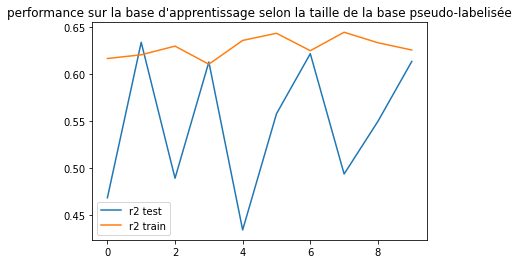

In [ ]:
plt.title("Performance du score R2 selon la taille de la base pseudo-labelisée")
plt.plot(r_test,  label='r2 test')
plt.plot(r_train,  label='r2 train')
plt.legend()

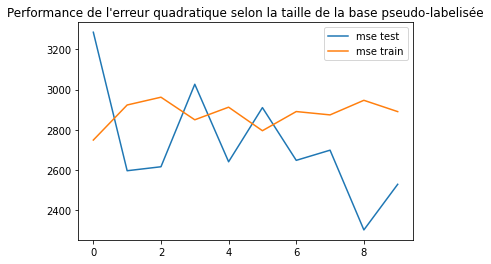

In [ ]:
plt.title("Performance de l'erreur quadratique selon la taille de la base pseudo-labelisée")
plt.plot(mse_test, label='mse test')
plt.plot(mse_train, label='mse train')
plt.legend()